In [15]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization, Conv1D,MaxPooling1D,Flatten
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [17]:
csv_files = [f for f in os.listdir() if f.lower().endswith('.csv')]

dfl = []
for idx, file in enumerate(csv_files, 1):
    df_temp = pd.read_csv(file)
    df_temp['region'] = idx
    dfl.append(df_temp)

df = pd.concat(dfl, ignore_index=True)

In [18]:
df['Time'] = pd.to_datetime(df['Time'])
df['year'] = df['Time'].dt.year
df['month'] = df['Time'].dt.month
df['day'] = df['Time'].dt.day
df['hour'] = df['Time'].dt.hour

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)


df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df.drop(columns=["hour", "month", "day", "year"], inplace=True)

In [19]:
df["Power_lag1"] = df["Power"].shift(1)

df["Power_diff"] = df["Power"] - df["Power"].shift(1)

df.dropna(inplace=True)

df["Power_log"] = np.log1p(df["Power"])

features = df.drop(columns=["Power", "Time", "Power_log"])

y_scaled = df["Power_log"].values.reshape(-1, 1)

feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(features)

In [29]:
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 48
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)
X_seq.shape, y_seq.shape

((175127, 72, 15), (175127, 1))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/128
986/986 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0033 - val_loss: 1.5006e-04
Epoch 2/128
986/986 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1.3276e-04 - val_loss: 1.2144e-04
Epoch 3/128
986/986 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 9.6395e-05 - val_loss: 1.0922e-04
Epoch 4/128
986/986 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 7.9474e-05 - val_loss: 9.7173e-05
Epoch 5/128
986/986 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 6.4142e-05 - val_loss: 9.1719e-05
Epoch 6/128
986/986 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 5.9073e-05 - val_loss: 1.0456e-04
Epoch 7/128
986/986 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 5.6071e-05 - val_loss: 8.8098e-05
Epoch 8/128
986/986 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 5.3956e-05 - val_loss: 8.8218e-05
Epoch 9/128
986/986 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 5.0080e-05 - val_loss: 7.5451e-05
Epoch 10/128
986/986 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 4.8302e-05 - val_loss: 6.9114e-05
Epoch 11/128
986/986 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms

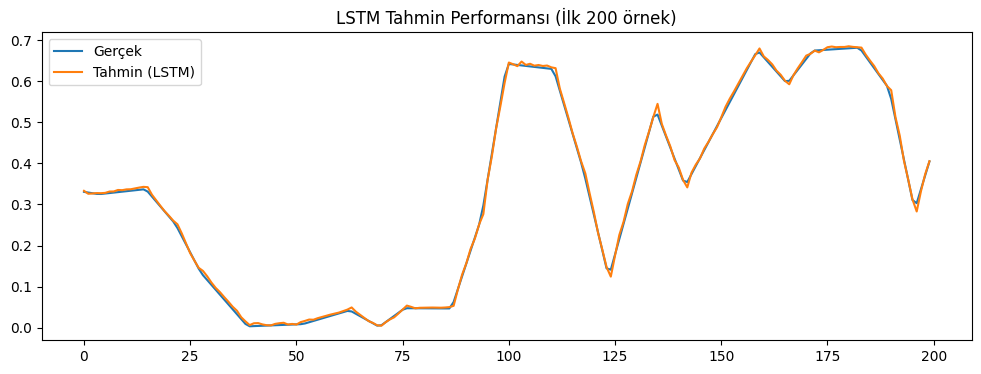

In [31]:
model2 = Sequential()
model2.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model2.fit(X_train, y_train, epochs=128, validation_split=0.1, batch_size=128, callbacks=[early_stop])
y_pred_log = model2.predict(X_test)

# Test verisi için tahmin
y_pred_log = model2.predict(X_test)
y_test_inv = np.expm1(y_test)
y_pred_inv = np.expm1(y_pred_log)

r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"Test R²: {r2:.4f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")

# Eğitim verisi için tahmin ve skor
y_train_pred = model2.predict(X_train)
y_train_inv = np.expm1(y_train)
y_pred_train_inv = np.expm1(y_train_pred)

r2_train = r2_score(y_train_inv, y_pred_train_inv)
mae_train = mean_absolute_error(y_train_inv, y_pred_train_inv)
rmse_train = np.sqrt(mean_squared_error(y_train_inv, y_pred_train_inv))

print(f"Train R²: {r2_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")

plt.figure(figsize=(12, 4))
plt.plot(y_test_inv[:200], label='Gerçek')
plt.plot(y_pred_inv[:200], label='Tahmin (LSTM)')
plt.title("LSTM Tahmin Performansı (İlk 200 örnek)")
plt.legend()
plt.show()